<a href="https://colab.research.google.com/github/ErDevanshgupta/BITCOIN-PRICE-PREDICTION/blob/main/Bitcoin_cost_Precdiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20')
df.head

<bound method NDFrame.head of           Timestamp     Open     High      Low    Close  Volume_(BTC)  \
0        1325317920     4.39     4.39     4.39     4.39      0.455581   
1        1325317980     4.39     4.39     4.39     4.39      0.455581   
2        1325318040     4.39     4.39     4.39     4.39      0.455581   
3        1325318100     4.39     4.39     4.39     4.39      0.455581   
4        1325318160     4.39     4.39     4.39     4.39      0.455581   
...             ...      ...      ...      ...      ...           ...   
3045852  1508457360  5690.88  5690.88  5690.88  5690.88      0.168941   
3045853  1508457420  5698.13  5704.10  5695.63  5704.10      2.311662   
3045854  1508457480  5695.62  5695.64  5694.00  5695.64      0.129647   
3045855  1508457540  5700.39  5700.39  5698.69  5698.69      0.085426   
3045856  1508457600  5700.00  5700.00  5698.68  5700.00      0.116847   

         Volume_(Currency)  Weighted_Price  
0                 2.000000        4.390000  
1  

In [6]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

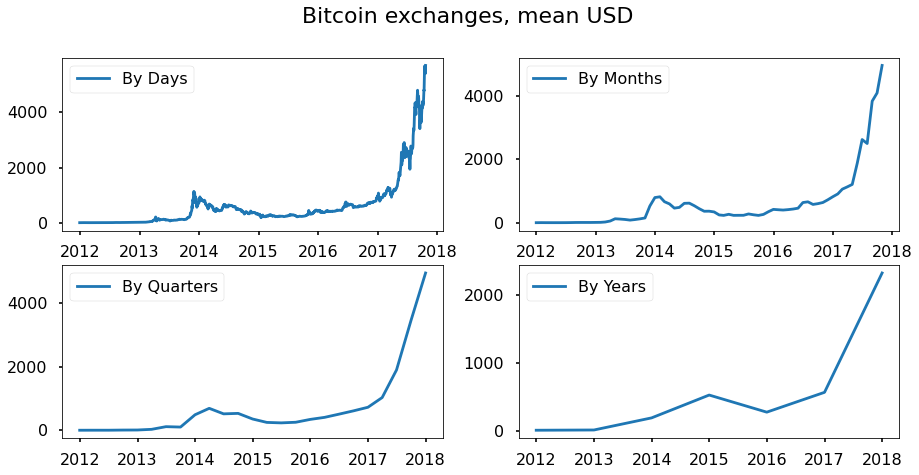

In [7]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months

**Stationarity check and STL-decomposition of the
series**

Dickey–Fuller test: p=1.000000


<Figure size 1080x504 with 0 Axes>

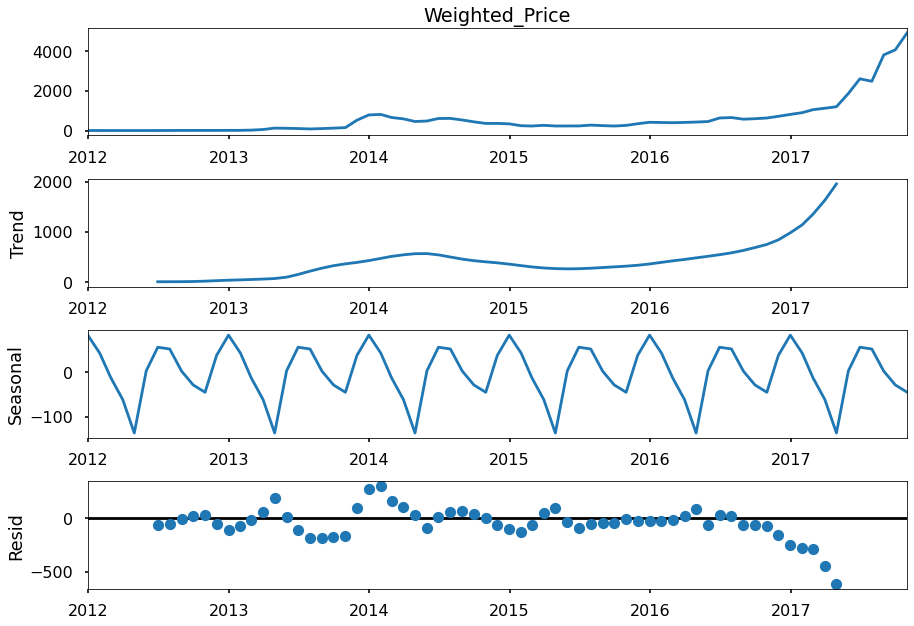

In [8]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

The series are not stationary.


**BOX-COX TRANSFORMATIONS**

In [9]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=1.000000


The series are not stationary.

**SEASONAL DIFFERENTIATION**

In [10]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.166401


The series are not stationary.

**REGULAR DIFFERENTIATION**

Dickey–Fuller test: p=0.024551


<Figure size 1080x504 with 0 Axes>

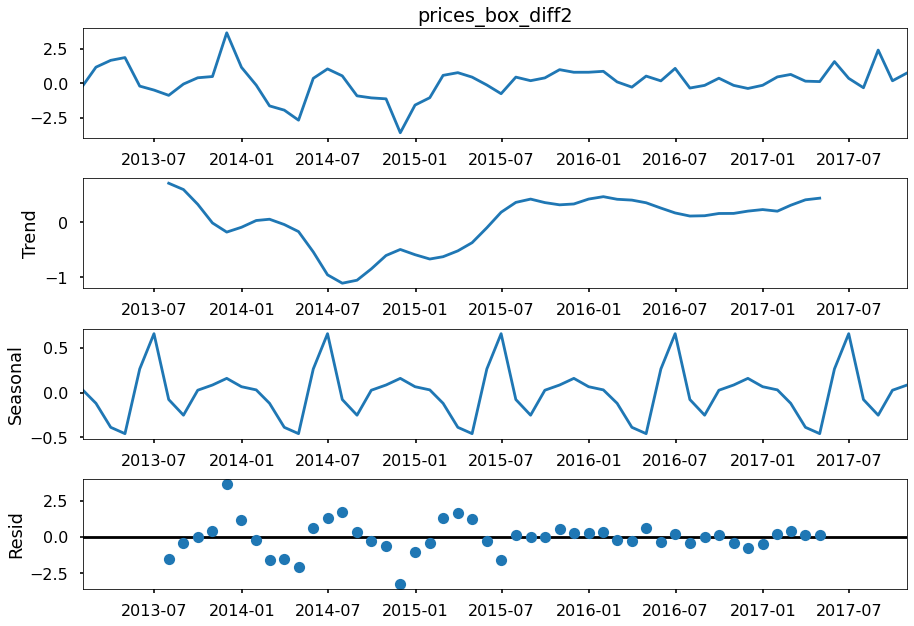

In [11]:
 #Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

**MODEL SELECTION**

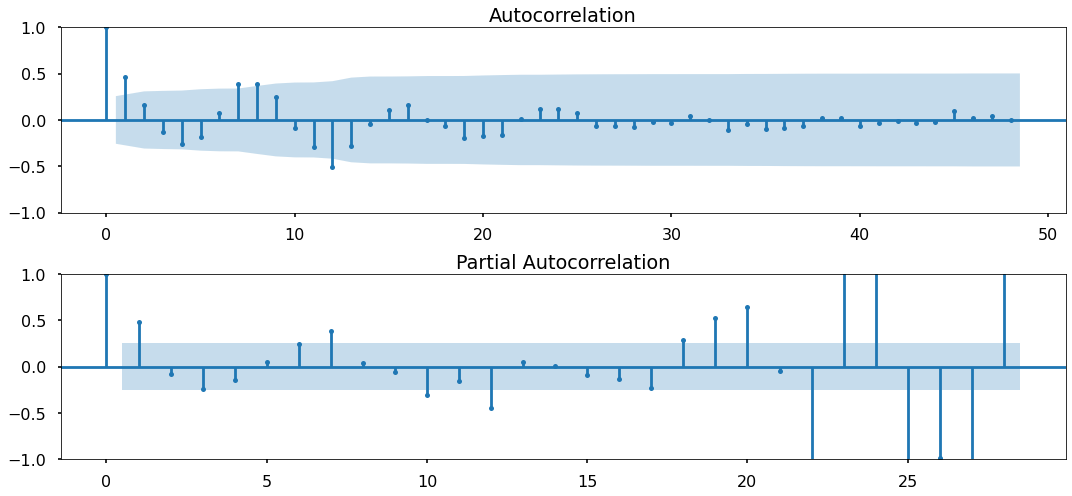

In [19]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=28, ax=ax)
plt.tight_layout()
plt.show()


In [20]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary)

      parameters         aic
49  (2, 2, 0, 1)  145.154089
19  (1, 0, 0, 1)  146.056353
21  (1, 0, 1, 1)  146.829628
51  (2, 2, 1, 1)  147.106373
50  (2, 2, 1, 0)  147.129927
<bound method SARIMAXResults.summary of <statsmodels.tsa.statespace.sarimax.SARIMAXResults object at 0x7f9579317730>>


Dickey–Fuller test:: p=0.000000


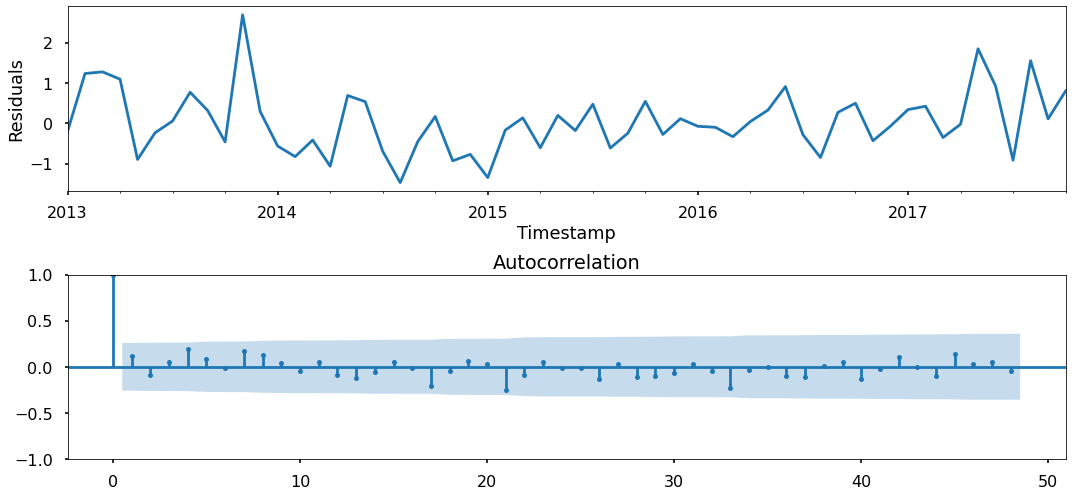

In [23]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [24]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))